# Import Data

First, we are going to import a small subset of the total data for exploratory data analysis. We are only interested in the tweets written in English.

In [1]:
# Import Packages
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import nltk
import random
import gensim
import pyLDAvis.gensim
import pickle
from pprint import pprint
from glob import glob
from nltk import TweetTokenizer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
# Import all data
filenames = glob('Data/IRA*.csv')

df = pd.concat([pd.read_csv(f) for f in filenames])

In [3]:
# Select tweets in English
df = df[df['language'] == "English"]

# Convert date
df['publish_datetime'] = pd.to_datetime(df['publish_date'])
# Create generalized day for plotting
df['publish_date'] = df['publish_datetime'].dt.floor('d')

# Get rid of retweets here for consistency?

In [4]:
# Get rid of URLS for safety purposes
def drop_urls(tweet_content):
    """ Drops urls from tweets. Some tweets link to links I don't want to link to...
    """
    drop_url = re.sub(r"http\S+", "", tweet_content, flags=re.MULTILINE)
    return drop_url

df['content'] = df['content'].apply(drop_urls)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


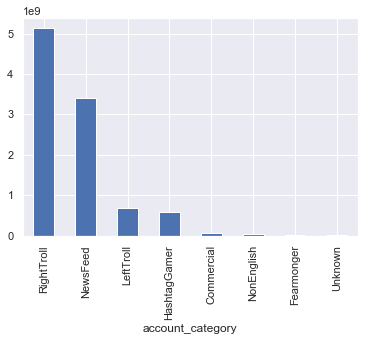

In [5]:
df_cat_updates = df.groupby('account_category')['updates'].sum().sort_values(ascending=False)

cat_plot = df_cat_updates.plot.bar()

In [6]:
accounts_max = df.groupby(['account_category', 'author']).max()

In [7]:
accounts_max.describe()

alt_external_id  external_author_id     followers     following  \
count     7.170000e+02        7.170000e+02    717.000000    717.000000   
mean      2.404861e+17        2.404845e+17   1617.002789   1509.952580   
std       3.879692e+17        3.879669e+17   5462.836277   3148.038684   
min       3.497640e+07        3.497640e+07      0.000000      0.000000   
25%       1.723227e+09        1.723227e+09     58.000000     74.000000   
50%       2.559217e+09        2.559217e+09    149.000000    291.000000   
75%       7.528907e+17        7.530000e+17    814.000000   1627.000000   
max       9.123939e+17        9.123940e+17  59100.000000  31547.000000   

       new_june_2018     retweet      tweet_id        updates  
count     717.000000  717.000000  7.170000e+02     717.000000  
mean        0.260809    0.810321  7.682746e+17    2938.403068  
std         0.439382    0.392321  1.067960e+17    8244.957072  
min         0.000000    0.000000  4.574222e+17       1.000000  
25%         0.000000    1.000000  6.707078e+17     307.000000  
50%         0.000000    1.000000  7.433616e+17     677.000000  
75%         1.000000    1.000000  8.892551e+17    2876.000000  
max         1.000000    1.000000  9.766389e+17  166113.000000

## Tweets by Category

In [8]:
# Define count_entries()
def count_entries(df, *args):
    """Return a dictionary with counts of
    occurrences as value for each key."""
    
    #Initialize an empty dictionary: cols_count
    cols_count = {}
    
    # Iterate over column names in args
    for col_name in args:
    
        # Extract column from DataFrame: col
        col = df[col_name]
    
        # Iterate over the column in DataFrame
        for entry in col:
    
            # If entry is in cols_count, add 1
            if entry in cols_count.keys():
                cols_count[entry] += 1
    
            # Else add the entry to cols_count, set the value to 1
            else:
                cols_count[entry] = 1

    # Return the cols_count dictionary
    return cols_count

# Call count_entries(): result
cat_count = count_entries(df, 'account_category')

cat_count

{'NewsFeed': 157403,
 'LeftTroll': 159216,
 'RightTroll': 330463,
 'HashtagGamer': 122365,
 'Fearmonger': 2574,
 'NonEnglish': 6421,
 'Unknown': 1495,
 'Commercial': 12416}

# Basic Visualizations

These tweets occur over SUCH AND SUCH TIME. We will visualize as follows:

In [9]:
def grouped_daily_sum(tweets):
    
    #grouped_df = df.groupby(['account_category']).mean()
    grouped_daily = df.groupby(['publish_date','account_category']).size().reset_index(name='counts')
    return grouped_daily

daily_tweets = grouped_daily_sum(df)
daily_tweets.head()

publish_date account_category  counts
0   2012-02-06        LeftTroll       1
1   2012-02-07        LeftTroll       1
2   2012-02-08        LeftTroll       1
3   2012-02-14        LeftTroll       1
4   2012-02-29        LeftTroll       1

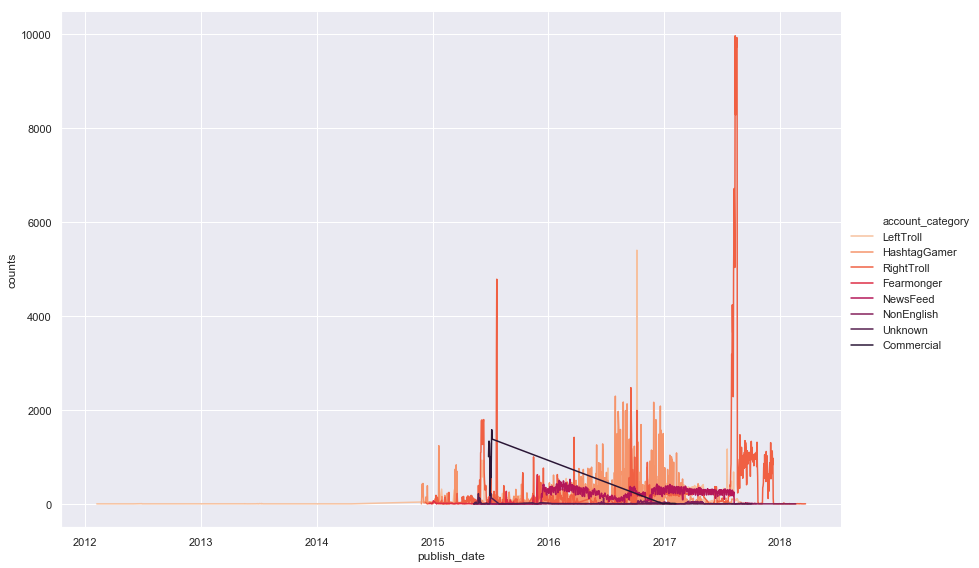

In [10]:
# Define a palette
palette = dict(zip(daily_tweets['account_category'].unique(),
                   sns.color_palette("rocket_r", 8)))

# Plot the lines on two facets
sns.relplot(data=daily_tweets,
            x='publish_date', y='counts',
            hue='account_category',
            palette=palette,
            height=8, aspect=12/8,
            kind="line", legend="full")

# Network Analysis

We are interested in the structure of the social network within which these accounts reside. 

From this dataset, we are only able to create a **mentions network**, since we do not have data regarding who has retweeted these tweets. In particular, we are intereset in which IRA accounts mention other IRA accounts, and how often. 

First, we need to create a function which uses regular expressions to extract the Twitter handles mentioned in each tweet. 


Then, we will create a function to construct a graph of mentions. This will be a directed graph, where each node represent an IRA account and each edge represents a direct mention.

In [11]:
def extract_usernames(tweet_content):
    """Function to extract usernames from tweets, accounting for email addresses
    """
    drop_emails = re.sub("[\w]+@[\w]+\.[c][o][m]", "", tweet_content)
    mentioned_users = re.findall("@([a-zA-Z0-9]{1,15})", drop_emails)
    return mentioned_users

# Create test data
test_tweets = df[['external_author_id','author',str('content'), 'retweet', 'account_category']]#.sample(50000, random_state=345)

# Filter out retweets
test_tweets = test_tweets[(test_tweets['retweet'] != 1) & (~test_tweets['content'].str.contains("RT"))]

# Apply username extraction function
test_tweets['mentions'] = test_tweets['content'].apply(extract_usernames)
test_tweets.head()

<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<ipython-input-11-d8e64270c63f>:4: DeprecationWarning: invalid escape sequence \w
  drop_emails = re.sub("[\w]+@[\w]+\.[c][o][m]", "", tweet_content)


external_author_id        author  \
0          2495567768  DAILYSANFRAN   
1          2495567768  DAILYSANFRAN   
2          2495567768  DAILYSANFRAN   
3          2495567768  DAILYSANFRAN   
4          2495567768  DAILYSANFRAN   

                                             content  retweet  \
0  Police: Airline pilot found passed out in cock...        0   
1  Dashcam video shows man launching himself onto...        0   
2  Man Arrested For Setting Fire To South SF Medi...        0   
3  Practical tips to achieving your New Year's re...        0   
4         Couple disappears during trip to Big Sur          0   

  account_category mentions  
0         NewsFeed       []  
1         NewsFeed       []  
2         NewsFeed       []  
3         NewsFeed       []  
4         NewsFeed       []

In order to create a graph from this data, we need to unnest the mentions such that each mention represents a pairing between one 'author' and one 'mention'. Each account will represent a node, and each mention will represent an edge between them.

In [12]:
# Unnest multiple username mentions in tweet
expanded_mentions = pd.DataFrame({'author':test_tweets['author'].repeat(test_tweets['mentions'].str.len()),
                           'mentions':np.concatenate(test_tweets['mentions'].values),
                           'account_category':test_tweets['account_category'].repeat(test_tweets['mentions'].str.len())})
expanded_mentions['mentions'] = expanded_mentions['mentions'].str.upper()
expanded_mentions.head()

author       mentions account_category
473    DAILYSANFRAN           UBER         NewsFeed
27659  DAILYSANJOSE      SANJOSEPD         NewsFeed
27669  DAILYSANJOSE       WARRIORS         NewsFeed
28616  DAILYSANJOSE  SANJOSESHARKS         NewsFeed
28829  DAILYSANJOSE      SANJOSEPD         NewsFeed

In this case, we are only interested in mentions of other IRA accounts. Note that sometimes IRA accounts mention themselves in a tweet. INCLUDE EXAMPLES OF THIS?

In [13]:
# Select only mentions of IRA accounts.
IRA_authors = df['author'].unique()

expanded_IRA_mentions = expanded_mentions[(expanded_mentions['mentions'].isin(IRA_authors))]
expanded_IRA_mentions

author         mentions account_category
51622       DANAGEEZUS   ANDYHASHTAGGER     HashtagGamer
51659       DANAGEEZUS       DANAGEEZUS     HashtagGamer
53928       DANAGEEZUS      CHRIXMORGAN     HashtagGamer
54453       DANAGEEZUS      CHRIXMORGAN     HashtagGamer
55662       DANAGEEZUS        CASCASEYP     HashtagGamer
55864       DANAGEEZUS        CASCASEYP     HashtagGamer
56097       DANAGEEZUS   ANDYHASHTAGGER     HashtagGamer
56495       DANAGEEZUS      CHRIXMORGAN     HashtagGamer
57534       DANAGEEZUS   ANDYHASHTAGGER     HashtagGamer
58785       DANAGEEZUS   ANDYHASHTAGGER     HashtagGamer
58800       DANAGEEZUS   ANDYHASHTAGGER     HashtagGamer
59281       DANAGEEZUS      ANTIEHARMON     HashtagGamer
59304       DANAGEEZUS   ANDYHASHTAGGER     HashtagGamer
59385       DANAGEEZUS       DANAGEEZUS     HashtagGamer
59387       DANAGEEZUS   ANDYHASHTAGGER     HashtagGamer
59624       DANAGEEZUS       DANAGEEZUS     HashtagGamer
59637       DANAGEEZUS   ANDYHASHTAGGER     HashtagGamer
59829       DANAGEEZUS       DANAGEEZUS     HashtagGamer
60170       DANAGEEZUS   ANDYHASHTAGGER     HashtagGamer
61066       DANAGEEZUS      CHRIXMORGAN     HashtagGamer
61511       DANAGEEZUS     CURTISBIGMAN     HashtagGamer
61860       DANAGEEZUS      CHRIXMORGAN     HashtagGamer
62933       DANAGEEZUS   ANDYHASHTAGGER     HashtagGamer
90138         DAVBOYD_     DONNABRIVERA       RightTroll
133142         DEUSXYX   CYNTHIAMHUNTER       RightTroll
135209   DEVINEDEVINBR    ARCHIEOLIVERS       RightTroll
138065      DICKYIRWIN      BGARNER2107     HashtagGamer
161516    DONTSHOOTCOM     DONTSHOOTCOM        LeftTroll
164585    DOROTHIEBELL     DONNABRIVERA       RightTroll
164587    DOROTHIEBELL     DONNABRIVERA       RightTroll
...                ...              ...              ...
8995          4MYSQUAD         4MYSQUAD        LeftTroll
9754          4MYSQUAD         4MYSQUAD        LeftTroll
15088     ABIGAILSSILK        DANBR00KS     HashtagGamer
15211     ABIGAILSSILK        DANBR00KS     HashtagGamer
15228     ABIGAILSSILK        DANBR00KS     HashtagGamer
36035        ADRGREERR  CHESTERCITYNEWS        LeftTroll
89183     AMANDAVGREEN      CHRIXMORGAN     HashtagGamer
144985        ANDROFAG          BYDRBRE       NonEnglish
147800  ANDYHASHTAGGER   ANDYHASHTAGGER     HashtagGamer
148827  ANDYHASHTAGGER      CHRIXMORGAN     HashtagGamer
151149  ANDYHASHTAGGER       DANAGEEZUS     HashtagGamer
151149  ANDYHASHTAGGER       DANAGEEZUS     HashtagGamer
151150  ANDYHASHTAGGER       DANAGEEZUS     HashtagGamer
151662  ANDYHASHTAGGER       DANAGEEZUS     HashtagGamer
151698  ANDYHASHTAGGER       DANAGEEZUS     HashtagGamer
152676  ANDYHASHTAGGER       DANAGEEZUS     HashtagGamer
154759  ANDYHASHTAGGER        AIDEN7757     HashtagGamer
155176  ANDYHASHTAGGER      ARONHOLDEN8     HashtagGamer
155492  ANDYHASHTAGGER       DANAGEEZUS     HashtagGamer
155594  ANDYHASHTAGGER       DANAGEEZUS     HashtagGamer
156333  ANDYHASHTAGGER       DANAGEEZUS     HashtagGamer
156351  ANDYHASHTAGGER  ANDYDREWDANIELS     HashtagGamer
156406  ANDYHASHTAGGER      CHRIXMORGAN     HashtagGamer
156479  ANDYHASHTAGGER      CHRIXMORGAN     HashtagGamer
156552  ANDYHASHTAGGER       DANAGEEZUS     HashtagGamer
156553  ANDYHASHTAGGER       DANAGEEZUS     HashtagGamer
156626  ANDYHASHTAGGER      CHRIXMORGAN     HashtagGamer
156724  ANDYHASHTAGGER       DANAGEEZUS     HashtagGamer
157157   ANFINRUDSADIE     ALEXWARNINGU       RightTroll
198601     AN_N_GASTON      CALEBROBBNS       RightTroll

[187 rows x 3 columns]

This network of mentions can be visualized using NetworkX. This is a directed graph, where the direction of the arrow represents a mention.

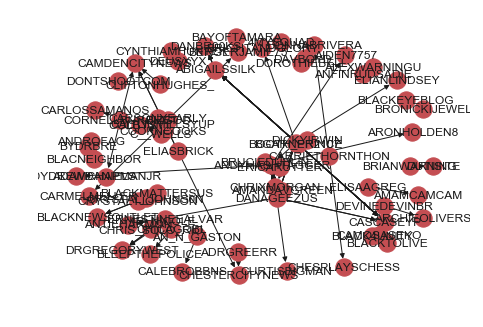

In [14]:
G=nx.from_pandas_edgelist(expanded_IRA_mentions,source='author',target='mentions',
                         edge_attr=True, create_using=nx.MultiDiGraph)
nx.draw(G, with_labels=True)

I am interested in betweenness centrality, which measures which users act as "bridges" between the network. For a more in-depth coverage of network measures, see https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/.

In [15]:
bet_cent = nx.betweenness_centrality(G, normalized = True)
bet_cent

{'DANAGEEZUS': 0.003423317683881064,
 'ANDYHASHTAGGER': 0.005477308294209703,
 'CHRIXMORGAN': 0.001564945226917058,
 'CASCASEYP': 0.0,
 'ANTIEHARMON': 0.0,
 'CURTISBIGMAN': 0.0,
 'DAVBOYD_': 0.0,
 'DONNABRIVERA': 0.0,
 'DEUSXYX': 0.0,
 'CYNTHIAMHUNTER': 0.0,
 'DEVINEDEVINBR': 0.0,
 'ARCHIEOLIVERS': 0.0,
 'DICKYIRWIN': 0.0,
 'BGARNER2107': 0.0010758998435054772,
 'DONTSHOOTCOM': 0.0,
 'DOROTHIEBELL': 0.0,
 'ELIASBRICK': 0.0,
 'CAMDENCITYNEWS': 0.0,
 'CHESTERCITYNEWS': 0.0,
 'ELISAAGREG': 0.0,
 'AMAMCAMCAM': 0.0,
 'ERICARUTTER': 0.0,
 'ERNESTINEEALVAR': 0.0,
 'DRGREGORYWEST': 0.0,
 'BERGERJAMIE75': 0.0005868544600938967,
 'BAYOFTAMARA': 0.0,
 'ABIGAILSSILK': 0.0005868544600938967,
 'BIZGOD': 0.0,
 'CAITLINMILLSYUP': 0.0011737089201877935,
 'BLACK4UNITY': 0.0,
 'BLACKTOLIVE': 0.0,
 'BLACKEYEBLOG': 0.0,
 'BLACKMATTERSUS': 0.0,
 'CRYSTAL1JOHNSON': 0.0003912363067292645,
 'BLACKNEWSOUTLET': 0.0,
 'BLACNEIGHBOR': 0.0,
 'BLEEPTHEPOLICE': 0.0,
 'BOOTH_PRINCE': 0.0,
 'ELIANLINDSEY': 0.0,
 'BRIGH

(-1.1496972532673533,
 1.1787275470198435,
 -1.173806550937894,
 1.2065608034827864)

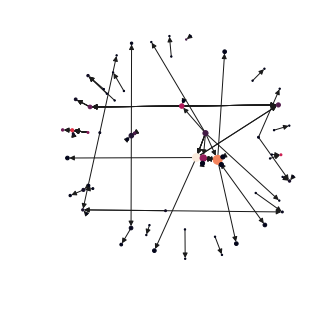

In [16]:
pos = nx.spring_layout(G)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(5,5))
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

#code adapted from https://www.datacamp.com/community/tutorials/social-network-analysis-python

In [17]:
sorted(betCent, key=betCent.get, reverse=True)[:5]

['ANDYHASHTAGGER',
 'DANAGEEZUS',
 'CHRIXMORGAN',
 'BOOTH_PRINCE',
 'CAITLINMILLSYUP']

# Key Influencers 

We can see that there are a few accounts which stand out as being influential. What are their common characteristics?

# Topic Detection

LDA resources: https://www.kaggle.com/errearanhas/topic-modelling-lda-on-elon-tweets

https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/





## Clean Text

In [18]:
# Create tokens from tweet
tokenizer = TweetTokenizer(strip_handles=True, reduce_len = True)
tokenizer.tokenize(df['content'].iloc[0])

['Police',
 ':',
 'Airline',
 'pilot',
 'found',
 'passed',
 'out',
 'in',
 'cockpit',
 'was',
 'drunk']

In [47]:
# Use Wordnet for meaning/synonyms/antonyms/lemmatizer(base of word)
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else: 
        return lemma

from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [48]:
# Filter out stopwords
en_stop = set(nltk.corpus.stopwords.words('english'))

In [54]:
# Function to tie together previous functions and process text
def prepare_text_for_lda(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [55]:
def convert_text_data(f):
    text_data = []
    for line in f:
        tokens = prepare_text_for_lda(line)
#        if random.random() > .99:
        text_data.append(tokens)    # indent if previous line correct
    return text_data
            
text_data = convert_text_data(df['content'])

In [161]:
text_data[0]

['Police', 'Airline', 'pilot', 'found', 'pass', 'cockpit', 'drunk']

In [97]:
from gensim.models import Word2Vec

model = Word2Vec(text_data, size=150, window=10, min_count=2, workers=10)
# Don't train again! model.train(text_data, total_examples=len(text_data), epochs=10)
word_vectors = model.wv

In [159]:
result = word_vectors.most_similar(positive=['hillary'], negative = [], topn=10)
result

[('clinton', 0.6399332880973816),
 ('trump', 0.6381477117538452),
 ('amuse', 0.6130398511886597),
 ('bernie', 0.6036626696586609),
 ('obama', 0.5923692584037781),
 ('putin', 0.5911301970481873),
 ('incompetent', 0.5780301094055176),
 ('precisely', 0.5747838616371155),
 ('whine', 0.5746846199035645),
 ('pathetic', 0.5730102062225342)]

In [162]:
model.wv.similarity(w1 = "barack", w2 = "obama")

0.40640613

## LDA 

In [25]:
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [26]:
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [27]:
number_of_topics = 30
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = number_of_topics, id2word=dictionary, passes = 1)
ldamodel.save('model5.gensim')

In [28]:
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    pprint(topic)

(36,
 '0.035*"Terror" + 0.029*"Declares" + 0.023*"Saturday" + 0.022*"track" + '
 '0.019*"Guard" + 0.016*"Canada" + 0.013*"Night" + 0.011*"Coast" + '
 '0.008*"AMERICA" + 0.005*"FIGHT" + 0.005*"STOOD" + 0.005*"Threats" + '
 '0.004*"NOTHING" + 0.004*"HOSTAGE" + 0.004*"Nuclear"')
(97,
 '0.043*"criminal" + 0.010*"decent" + 0.005*"think" + 0.003*"CRIMINAL" + '
 '0.001*"KayHair" + 0.001*"She\'s" + 0.001*"Decency" + 0.000*"invasion" + '
 '0.000*"appease" + 0.000*"Eastern" + 0.000*"Crimea" + 0.000*"Barrymore" + '
 '0.000*"Decline" + 0.000*"CHESNEY" + 0.000*"URBAN"')
(35,
 '0.288*"protest" + 0.275*"march" + 0.013*"Force" + 0.011*"Health" + '
 '0.011*"billion" + 0.010*"expose" + 0.010*"Trump" + 0.009*"trend" + '
 '0.007*"waste" + 0.006*"Rights" + 0.005*"Mental" + 0.005*"study" + '
 '0.005*"People" + 0.005*"reportedly" + 0.005*"remind"')
(17,
 '0.108*"black" + 0.058*"friend" + 0.054*"Another" + 0.036*"supporter" + '
 '0.031*"light" + 0.030*"follow" + 0.023*"Trump" + 0.020*"Martin" + '
 '0.014*"THA

In [30]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.enable_notebook(lda_display)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Sentiment Analysis

Previous studies have show that influential Twitter accounts tend to have a distinct sentiment. We will be using VADER:  "VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media."

Define: positive, negative, neutral - score percentage of each category
        compound - single score representing the sentiment (-1 negative, 0 neutral, 1 positive)

In [ ]:
tweet_text = test_tweets['content'].sample(n=100000, random_state = 210)

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
sentiment_values = []

for tweet in tweet_text:
    pol_score = sia.polarity_scores(tweet)
    pol_score['tweet'] = tweet
    sentiment_values.append(pol_score)

In [ ]:
pd.set_option('display.max_colwidth', -1)

sentiment = pd.DataFrame.from_records(sentiment_values)
sentiment.head(n=10)

There is not a uniform distribution of sentiment among tweets. Most tweets are either neutral or negative:

NOTE: this pdf is misleading since algorithm is biased towards 0

In [ ]:
sns.distplot(sentiment['compound'])
plt.axvline(.2, 0, 1,linestyle = '--')
plt.axvline(-.2, 0, 1,linestyle = '--')

In order to further analyze this dataset, we are going to split the tweets into positive or negative, ignoring the neutral tweets for now. We will use +/-0.2 as the cutoff, as seen above.

In [ ]:
sentiment['label'] = 0
sentiment.loc[sentiment['compound'] > 0.2, 'label'] = 1
sentiment.loc[sentiment['compound'] < -0.2, 'label'] = -1
sentiment.head()

In [ ]:
pd.set_option('display.max_colwidth', -1)

print("Positive headlines:\n")
print(sentiment.loc[sentiment['label'] == 1].head())

print("Negative headlines:\n")
print(sentiment.loc[sentiment['label'] == -1].head())

# This section needs serious reformatting

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = sentiment.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

# Things to Investigate / Incorporate

    Strong postive correlation between followers - following.
    
    There is a hashtagger account named "Andy Hashtagger"
    
    "Flatulence and global warming: are we farting ourselves into extinction? #RejectedDebateTopics"
    
    1. Create new features
        a. botometer score of mentioned accts which are still active
        b. sentiment score of tweets
        c. some ratio of followers/following/participation
        d. import news channels and see who mentions which news channels
    2. Use these features to predict updates
    
    What states do these people list in their bio? Does that correlate with anything?
    
    Do positive sentiment tweets containing words relating to psuedoscience count as endorsement?